This is a simple, supervised denoising model run on ImageNet. This code is essentially identical to `n2n_imagenet.ipynb` except it uses `SupervisedDenoisingGenerator` for both training and testing.

In [18]:
import numpy as np
import keras
from importlib import reload
import os

from helpers import generators, utils, noise_models
from models import unet_n2n, irfan_2020

In [19]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

utils.check_gpu_use()

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
!pip show tensorflow 

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/antrikshdhand/Documents/github/thesis-ml/ml/virt/lib/python3.9/site-packages
Requires: tensorflow-macos
Required-by: 


In [21]:
reload(generators)
reload(utils)
reload(noise_models)

<module 'helpers.noise_models' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/noise_models.py'>

In [22]:
np.random.seed(42)

## Initialise data

In [23]:
TRAIN_IMAGE_DIR = "../../raw_datasets/imagenet-10k"
VAL_IMAGE_DIR = "../../raw_datasets/BSDS300/images/train"
TEST_IMAGE_DIR = "../../raw_datasets/BSDS300/images/test"

NUM_EPOCHS = 50
GPU_BATCH_SIZE = 4
DATA_BATCH_SIZE = 16

In [24]:
noise_model = noise_models.gaussian_noise

In [25]:
train_gen = generators.SupervisedDenoisingGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

val_gen = generators.SupervisedDenoisingGenerator(
    image_dir=VAL_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

test_gen = generators.SupervisedDenoisingGenerator(
    image_dir=TEST_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

## Initialise model

In [26]:
# model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr, utils.ssim],
)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 192, 192, 64)         640       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 192, 192, 64)         0         ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 192, 192, 64)         36928     ['leaky_re_lu[0][0]']         
                                                                                               

## Train model

In [27]:
csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/supervised_denoiser_07122024/unet/training.log",
    separator=',',
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/supervised_denoiser_07122024/unet/tmp"
)

In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[csv_logger, backup_callback]
)

Epoch 1/50
625/625 - 781s - loss: 0.0108 - psnr: 22.0031 - ssim: 0.4802 - val_loss: 0.0045 - val_psnr: 24.3591 - val_ssim: 0.5969 - 781s/epoch - 1s/step
Epoch 2/50
625/625 - 743s - loss: 0.0040 - psnr: 25.1835 - ssim: 0.6278 - val_loss: 0.0029 - val_psnr: 26.5394 - val_ssim: 0.6850 - 743s/epoch - 1s/step
Epoch 3/50
625/625 - 750s - loss: 0.0031 - psnr: 26.5036 - ssim: 0.6856 - val_loss: 0.0026 - val_psnr: 26.9992 - val_ssim: 0.7100 - 750s/epoch - 1s/step
Epoch 4/50
625/625 - 755s - loss: 0.0028 - psnr: 27.1106 - ssim: 0.7120 - val_loss: 0.0028 - val_psnr: 27.0219 - val_ssim: 0.7047 - 755s/epoch - 1s/step
Epoch 5/50
625/625 - 755s - loss: 0.0026 - psnr: 27.5595 - ssim: 0.7306 - val_loss: 0.0024 - val_psnr: 27.5758 - val_ssim: 0.7300 - 755s/epoch - 1s/step
Epoch 6/50
625/625 - 754s - loss: 0.0025 - psnr: 27.8432 - ssim: 0.7410 - val_loss: 0.0022 - val_psnr: 28.2318 - val_ssim: 0.7691 - 754s/epoch - 1s/step
Epoch 7/50
625/625 - 762s - loss: 0.0024 - psnr: 28.0173 - ssim: 0.7491 - val_loss

In [29]:
# model.save("models/saved/supervised_denoiser_07122024/irfan/50epochs.keras")
model.save("models/saved/supervised_denoiser_07122024/unet/50epochs.keras")

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_98625/757559.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  together.show()


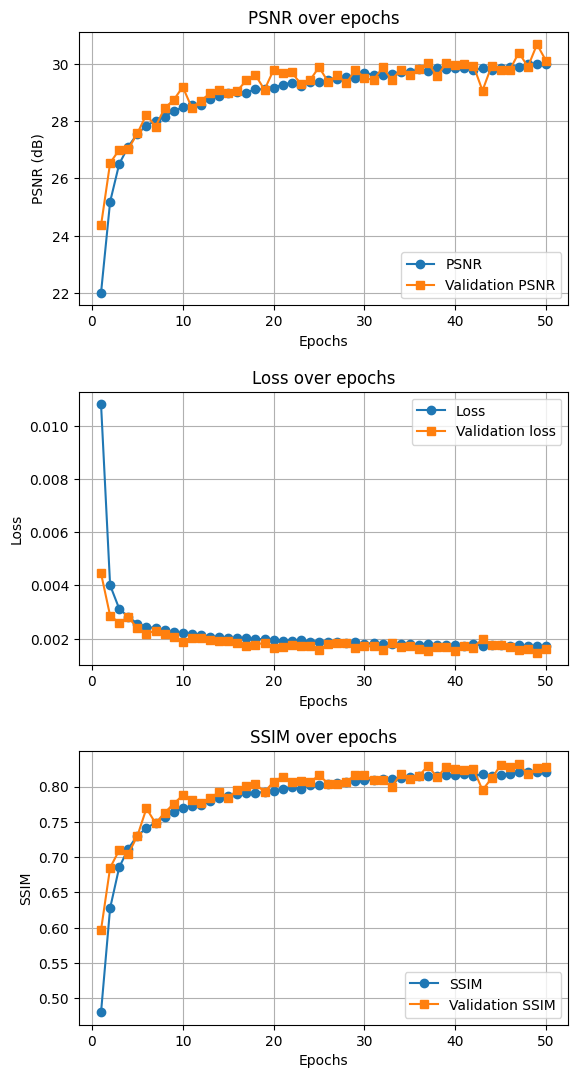

In [30]:
reload(utils)

together = utils.get_psnr_and_loss_curves(history, together=True, ssim=True)
# together.savefig('models/saved/supervised_denoiser_07122024/irfan/img/psnr_loss.pdf')
together.savefig('models/saved/supervised_denoiser_07122024/unet/img/psnr_loss.pdf')
together.show()

## Evaluate model

In [31]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

6/6 - 3s - loss: 0.0017 - psnr: 29.7796 - ssim: 0.8151 - 3s/epoch - 423ms/step


In [32]:
evals

[0.0016831749817356467, 29.779563903808594, 0.8151359558105469]

1/1 [==============================] - 1s 866ms/step


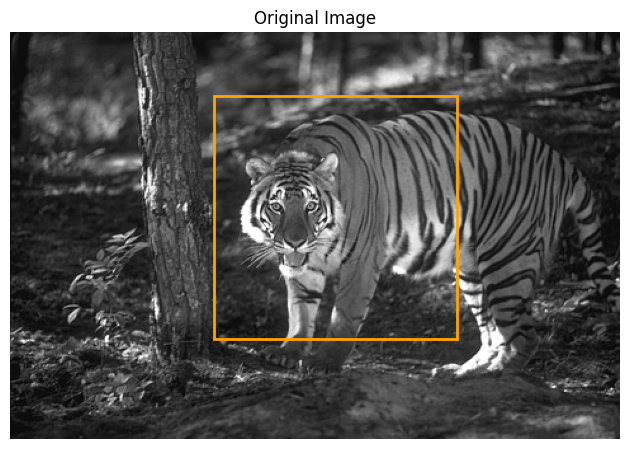

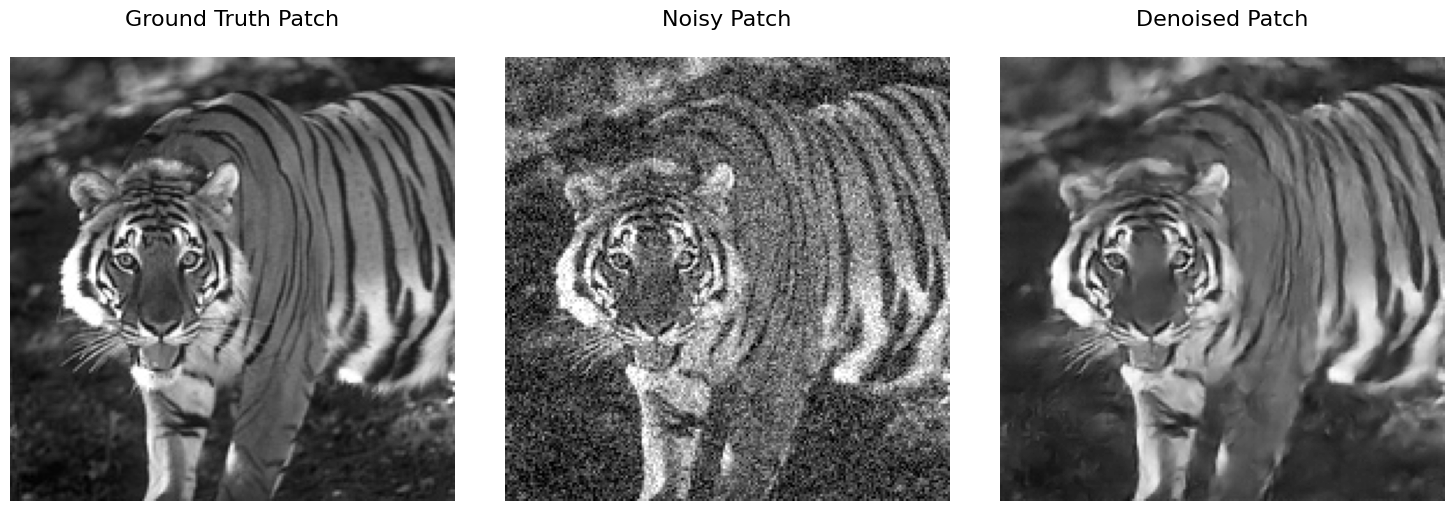

In [33]:
ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/108005.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(160, 50)
)

# ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/ground_truth_fig_1.pdf')
# patches_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/patches_fig_1.pdf')

ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/ground_truth_fig_1.pdf')
patches_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/patches_fig_1.pdf')

1/1 [==============================] - 0s 55ms/step


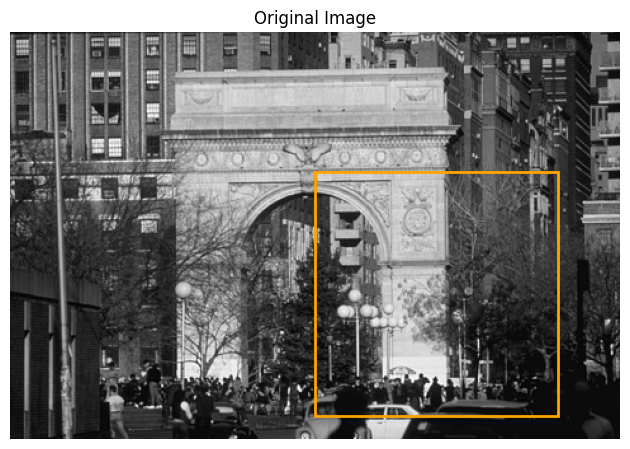

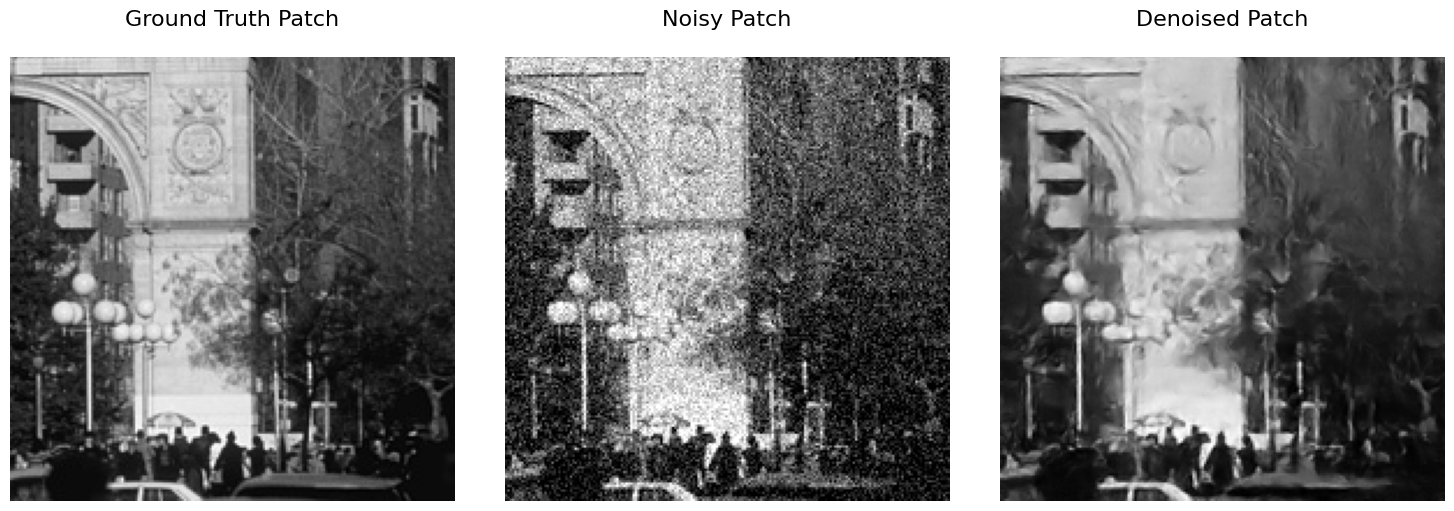

In [34]:
ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/148089.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(240, 110)
)

# ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/ground_truth_fig_2.pdf')
# patches_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/patches_fig_2.pdf')

ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/ground_truth_fig_2.pdf')
patches_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/patches_fig_2.pdf')